# Skip gram示例

一下代码使用的公式可以在[Word Embedding](../../nlp/word_embedding.ipynb)

代码实现参考[知乎文章](https://zhuanlan.zhihu.com/p/82683575)

In [1]:
import numpy as np
import torch
from torch import nn, optim
import random
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
text = """
Give me the strength lightly to bear my joys and sorrows 
Give me the strength to make my love fruitful in service Give me 
the strength never to disown the poor or bend my knees before 
insolent might Give me the strength to raise my mind high above 
daily trifles And give me the strength to surrender my strength 
to thy will with love
"""

In [3]:
#参数设置
EMBEDDING_DIM = 2    #词向量维度
PRINT_EVERY = 1000   #可视化频率
EPOCHS = 1000        #训练的轮数
BATCH_SIZE = 5       #每一批训练数据大小
N_SAMPLES = 3        #负样本大小
WINDOW_SIZE = 5      #周边词窗口大小
FREQ = 0             #词汇出现频率
DELETE_WORDS = False #是否删除部分高频词

In [4]:
#文本预处理
def preprocess(text: str, FREQ):
    text = text.replace("\n", "").lower()
    words = text.split()
    #去除低频词
    word_counts = Counter(words)
    return [word for word in words if word_counts[word] > FREQ]

words = preprocess(text, FREQ)

#构建词典
vocab = set(words)
vocab2int = {w: c for c, w in enumerate(vocab)}
int2vocab = {c: w for c, w in enumerate(vocab)}

#将文本转化为数值
int_words = [vocab2int[w] for w in words]

#计算单词频次
int_word_counts = Counter(int_words)
total_count = len(int_words)
word_freqs = {w: c/total_count for w, c in int_word_counts.items()}

#去除出现频次高的词汇
if DELETE_WORDS:
    t = 1e-5
    prob_drop = {w: 1-np.sqrt(t/word_freqs[w]) for w in int_word_counts}
    train_words = [w for w in int_words if random.random()<(1-prob_drop[w])]
else:
    train_words = int_words

In [5]:
word_freqs = np.array(list(word_freqs.values()))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist ** (0.75) / np.sum(unigram_dist ** (0.75)))

In [6]:
#获取目标词汇
def get_target(words, idx, WINDOW_SIZE):
    target_window = np.random.randint(1, WINDOW_SIZE+1)
    start_point = idx-target_window if (idx-target_window)>0 else 0
    end_point = idx+target_window
    targets = set(words[start_point:idx]+words[idx+1:end_point+1])
    return list(targets)

#批次化数据
def get_batch(words, BATCH_SIZE, WINDOW_SIZE):
    n_batches = len(words)//BATCH_SIZE
    words = words[:n_batches*BATCH_SIZE]
    for idx in range(0, len(words), BATCH_SIZE):
        batch_x, batch_y = [],[]
        batch = words[idx:idx+BATCH_SIZE]
        for i in range(len(batch)):
            x = batch[i]
            y = get_target(batch, i, WINDOW_SIZE)
            batch_x.extend([x]*len(y))
            batch_y.extend(y)
        yield batch_x, batch_y

In [7]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist):
        super().__init__()
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        #定义词向量层
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        #词向量层参数初始化
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
    #输入词的前向过程
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    #目标词的前向过程
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    #负样本词的前向过程
    def forward_noise(self, size, N_SAMPLES):
        noise_dist = self.noise_dist
        #从词汇分布中采样负样本
        noise_words = torch.multinomial(noise_dist,
                                        size * N_SAMPLES,
                                        replacement=True)
        noise_vectors = self.out_embed(noise_words).view(size, N_SAMPLES, self.n_embed)
        return noise_vectors

In [8]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        BATCH_SIZE, embed_size = input_vectors.shape
        #将输入词向量与目标词向量作维度转化处理
        input_vectors = input_vectors.view(BATCH_SIZE, embed_size, 1)
        output_vectors = output_vectors.view(BATCH_SIZE, 1, embed_size)
        #目标词损失
        test = torch.bmm(output_vectors, input_vectors)
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        #负样本损失
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)
        #综合计算两类损失
        return -(out_loss + noise_loss).mean()

In [9]:
#模型、损失函数及优化器初始化
model = SkipGramNeg(len(vocab2int), EMBEDDING_DIM, noise_dist=noise_dist)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

#训练
steps = 0
for e in range(EPOCHS):
    #获取输入词以及目标词
    for input_words, target_words in get_batch(train_words, BATCH_SIZE, WINDOW_SIZE):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        #输入、输出以及负样本向量
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        size, _ = input_vectors.shape
        noise_vectors = model.forward_noise(size, N_SAMPLES)
        #计算损失
        loss = criterion(input_vectors, output_vectors, noise_vectors)
        #打印损失
        if steps%PRINT_EVERY == 0:
            print("loss：",loss.item())
        #梯度回传
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

loss： 1.7468403577804565
loss： 1.867253303527832
loss： 1.2688109874725342
loss： 1.5140713453292847
loss： 1.7618025541305542
loss： 1.3929388523101807
loss： 1.440144419670105
loss： 2.0400619506835938
loss： 1.1393812894821167
loss： 1.3181675672531128
loss： 1.5457394123077393
loss： 1.1019389629364014


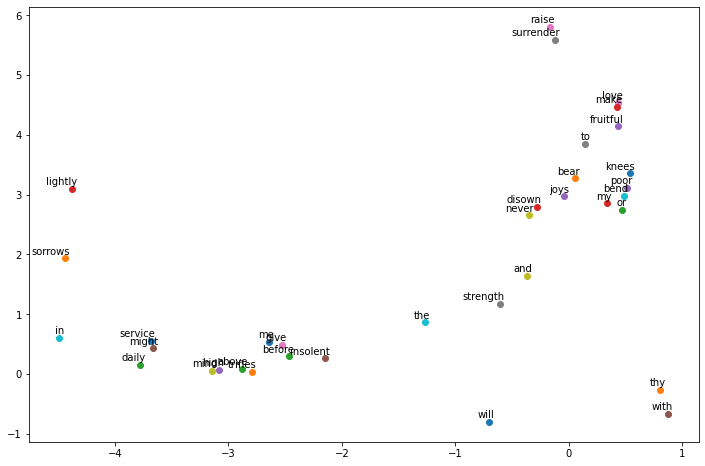

In [10]:
plt.figure(figsize=(12, 8))
for i, w in int2vocab.items():
    vectors = model.state_dict()["in_embed.weight"]
    x,y = float(vectors[i][0]),float(vectors[i][1])
    plt.scatter(x,y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()